Proyecto DS4A- E- COMMERCE

In [1]:
# Import the Pandas package
import pandas as pd

# Import the NumPy package
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata as unicode
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as sm
import statsmodels
from scipy import stats
from pingouin import pairwise_ttests
import snowflake.connector
import os
from scipy.stats import chi2_contingency

## 1. Import Datasets 

In [2]:
customers_dataset = pd.read_csv("Data/olist_customers_dataset.csv")#
geolocation_dataset = pd.read_csv("Data/olist_geolocation_dataset.csv")
order_items_dataset = pd.read_csv("Data/olist_order_items_dataset.csv")#
#order_payments_dataset = pd.read_csv("data/olist_order_payments_dataset.csv")
order_reviews_dataset = pd.read_csv("Data/olist_order_reviews_dataset.csv")#
orders_dataset = pd.read_csv("Data/olist_orders_dataset.csv")#
products_dataset = pd.read_csv("Data/olist_products_dataset.csv")#
seller_dataset = pd.read_csv("Data/olist_sellers_dataset.csv")#
product_category_name_translation = pd.read_csv("Data/product_category_name_translation.csv")#


![Captura.PNG](attachment:Captura.PNG)

data set that contain the id, unique id, the zip code, the citya and the state of the costumer


## 2. join the data sets and creade stadistics KPI'S


In [3]:
df_orders = pd.merge(customers_dataset,orders_dataset, how = "left", left_on = "customer_id", right_on = "customer_id")
df_orders = pd.merge(df_orders,order_reviews_dataset, how = "left", left_on = "order_id", right_on = "order_id")
#df_orders = pd.merge(mg_dataset2,seller_dataset,how = "left", left_on = "seller_id", right_on = "seller_id")
#mg_dataset2 = pd.merge(mg_dataset1,order_payments_dataset, how = "left", left_on ="order_id",right_on ="order_id")
#mg_dataset3 = pd.merge(mg_dataset2,order_reviews_dataset, how = "left", left_on = "order_id", right_on = "order_id")
#mg_dataset4 = pd.merge(mg_dataset3,order_items_dataset,how = "left", left_on = "order_id", right_on = "order_id")
#mg_dataset5 = pd.merge(mg_dataset4,products_dataset,how = "left", left_on = "product_id", right_on = "product_id")
#df = pd.merge(mg_dataset5,seller_dataset,how = "left", left_on = "seller_id", right_on = "seller_id")
#df = pd.merge(mg_dataset6,geolocation_dataset, how = "left", left_on = "customer_zip_code_prefix", right_on = "geolocation_zip_code_prefix")
df_items=pd.merge(order_items_dataset,products_dataset,how='left',left_on='product_id',right_on='product_id')
df_items=pd.merge(df_items,product_category_name_translation,how='left',left_on='product_category_name',right_on='product_category_name')
df_items=pd.merge(df_items,seller_dataset,how='left',left_on='seller_id',right_on='seller_id')



In [4]:


geolocation_dataset['geolocation_city']=geolocation_dataset['geolocation_city'].apply(lambda x: unicode.normalize('NFKD',x).encode("ascii","ignore").decode("ascii"))
geolocation_dataset['geolocation_city'].unique()


array(['sao paulo', 'sao bernardo do campo', 'jundiai', ...,
       'floriano peixoto', 'erebango', 'santa cecilia do sul'],
      dtype=object)

In [5]:
maxlat=5.25
minlat=-33.75
minlng=-74
maxlng=-29
geolocation_dataset=geolocation_dataset.drop(geolocation_dataset[(geolocation_dataset['geolocation_lat']>maxlat) | (geolocation_dataset['geolocation_lat']<minlat)|(geolocation_dataset['geolocation_lng']>maxlng) | (geolocation_dataset['geolocation_lng']<minlng)].index)
df_geo=geolocation_dataset.groupby('geolocation_zip_code_prefix').aggregate({'geolocation_lat':'mean','geolocation_lng':'mean'})
temp=geolocation_dataset.groupby(['geolocation_zip_code_prefix','geolocation_city','geolocation_state']).count().reset_index()

df_geo=df_geo.merge(temp[['geolocation_zip_code_prefix','geolocation_city','geolocation_state']],how='left',on='geolocation_zip_code_prefix')
df_geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1001,-23.550190,-46.634024,sao paulo,SP
1,1002,-23.548146,-46.634979,sao paulo,SP
2,1003,-23.548994,-46.635731,sao paulo,SP
3,1004,-23.549799,-46.634757,sao paulo,SP
4,1005,-23.549456,-46.636733,sao paulo,SP


In [6]:
df_orders=df_orders.merge(df_geo,how='left',right_on='geolocation_zip_code_prefix',left_on='customer_zip_code_prefix')


In [7]:
df_items=df_items.merge(df_geo,how='left',right_on='geolocation_zip_code_prefix',left_on='seller_zip_code_prefix')


In [8]:
df_items=df_items.merge(df_orders[['order_id','geolocation_lat','geolocation_lng']],how='left',on='order_id')
import math as math
def distancia(row):
    lat1=row['geolocation_lat_x']
    lat2=row['geolocation_lat_y']
    lng1=row['geolocation_lng_x']
    lng2=row['geolocation_lng_y']
    R_earth=6371
    dlat=math.radians(lat2-lat1)
    dlng=math.radians(lng2-lng1)
    a= (math.sin(dlat/2))**2+math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*((math.sin(dlng/2))**2)
    c=2*math.atan2(math.sqrt(a),math.sqrt(1-a))
    return R_earth*c

df_items['distance']=df_items.apply(lambda x:distancia(x),axis=1)
df_items["LIMIT_DATE"] = pd.to_datetime(df_items["shipping_limit_date"])
df_orders['order_estimated_delivery_date']=pd.to_datetime(df_orders['order_estimated_delivery_date'])
temp=df_items.groupby('order_id').agg({'product_id':'count','LIMIT_DATE':'max','distance':'max'}).reset_index()
temp.columns=['order_id','Q_products','Shipping_due_date','Distance']
df_orders=df_orders.merge(temp,how='left',on='order_id')


In [9]:
df_items["LIMIT_DATE"] = pd.to_datetime(df_items["shipping_limit_date"])
df_orders['order_estimated_delivery_date']=pd.to_datetime(df_orders['order_estimated_delivery_date'])
df_orders['order_delivered_customer_date']=pd.to_datetime(df_orders['order_delivered_customer_date'])
df_orders['Fulfill_date']= df_orders['order_delivered_customer_date']<df_orders['order_estimated_delivery_date']

Hasta aca quedaron dos tablas:

**df_ orders** que tiene un registro por cada compra en olist y dentro tiene:

1. Informacion de la orden
2. Informacion del cliente
3. Informacion del Review del cliente
4. Georeferenciacion del cliente

**df_items** que tiene un registro por cada item que se ha despachado y dentro tiene:

1. Informacion de cada producto
2. Numero de Orden  a la que esta relacionada
3. Informacion del vendedor (Cada item es despachada por un unico vendedor, pero una orden puede ser despachada por varios vendedores)
4. Georeferenciacion del vendedor

La informacion de **georeferenciacion** llega solo al zipcode del comprador y del vendedor, parece que le eliminaron la direccion, pero dejaron las coordenadas, por lo que incluir esta informacion hace que los registros se repitan la cantidad de clientes+vendedores que existan en el mismo zipcode

La informacion de pagos creo que puede ser relevante, pero tiene el problema de que el cliente puede hacer el pago con mas de un metodo, al final creo que la informacion relevante es que medio uso (solo hay 4 o 5 medios) y puede que tambien sea relevante en cuantas partes dividio el pago (numero maximo de payment_sequential)


**Sugerencia1**: En la tabla de reviews, hay ordenes que tienen mas de un review, debemos limpiarla y dejar el ultimo por fecha de registro del review (el cliente pudo cambiar de opinion o contestar la encuesta varias veces)

**Sugerencia 2**: Hacer con los pagos 5 variables categoricas para determinar los medios de pago que utilizo el cliente en cada ordes, agregar el numero de payments con el max de payment_sequential y llevar estas 6 variables a la tabla df_orders

In [10]:
df_orders.info() # Entendimiento de las variables.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103712 entries, 0 to 103711
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    103712 non-null  object        
 1   customer_unique_id             103712 non-null  object        
 2   customer_zip_code_prefix       103712 non-null  int64         
 3   customer_city                  103712 non-null  object        
 4   customer_state                 103712 non-null  object        
 5   order_id                       103712 non-null  object        
 6   order_status                   103712 non-null  object        
 7   order_purchase_timestamp       103712 non-null  object        
 8   order_approved_at              103547 non-null  object        
 9   order_delivered_carrier_date   101867 non-null  object        
 10  order_delivered_customer_date  100631 non-null  datetime64[ns]
 11  

Revisando la información de las variables que componen el Data Frame, nos damos cuenta que order_delivered_carrier_date,order_delivered_customer_date,review_comment_title y review_comment_message presentan valores NA dentro de sus columnas. adempas que tenemos un total de 100.000 registros unicos en la base haciendo referencia a las compras que hicieron los clientes


       DATE  customer_unique_id
0   2016-09                   4
1   2016-10                 336
2   2016-12                   1
3   2017-01                 843
4   2017-02                1849
5   2017-03                2790
6   2017-04                2507
7   2017-05                3862
8   2017-06                3377
9   2017-07                4201
10  2017-08                4532
11  2017-09                4466
12  2017-10                4840
13  2017-11                7908
14  2017-12                5944
15  2018-01                7608
16  2018-02                7056
17  2018-03                7531
18  2018-04                7193
19  2018-05                7152
20  2018-06                6403
21  2018-07                6552
22  2018-08                6737
23  2018-09                  16
24  2018-10                   4


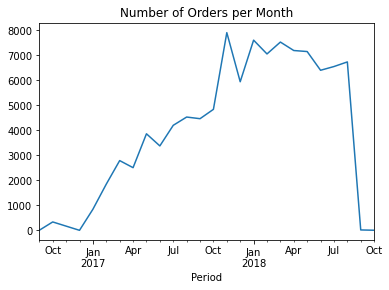

In [11]:
#Grafica del numero de ordenes por mes de análisis
df_orders["DATE"] = pd.to_datetime(df_orders["order_purchase_timestamp"])
df_orders["DATE"] = df_orders["DATE"].dt.to_period(freq = "M")

orders_by_month = df_orders.groupby('DATE')['customer_unique_id'].count().reset_index(drop = False)
print(orders_by_month)

#Line Plot for the Colission by date.

# Modificación Emmanuel G para embellecer las gráficas
# Inicio (1)
orders_by_month.plot(x= "DATE",y="customer_unique_id",title="Number of Orders per Month")
plt.xlabel("Period")    
plt.legend('',frameon=False)
#Fin (1)

Creación de una variable que calcule el tiempo que se demora en entregar un producto desde que se realizó la compra por la plataforma, pues puede ser una variable explicativa del socore de los clientes.


In [12]:
#CREACIÓN DE UNA VARIABLE DEL TIEMPO ENTRE COMPRA Y ENTREGA DE PRODUCTO
# Then with the remaining values, convert them to datetime objects
df_orders['order_delivered_customer_date'] = pd.to_datetime(df_orders['order_delivered_customer_date'], format='%Y/%m/%d %H:%M:%S')
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'], format='%Y/%m/%d %H:%M:%S')

df_orders['time_duration'] = (df_orders['order_delivered_customer_date'] - df_orders['order_purchase_timestamp'])
df_orders['time_duration'] = df_orders['time_duration'].apply(lambda x: x.days)
# At this point, its important to know the time duration since customer purchase and delivery.
df_orders = df_orders[df_orders.time_duration.notna()]
#Inicio (2)
df_describe = pd.DataFrame(df_orders['time_duration'].describe())
df_describe.columns = {'Time Duration'}
df_describe
#Fin (2)

,Time Duration
count,100631.000000
mean,12.123610
std,9.574398
min,0.000000
25%,6.000000
50%,10.000000
75%,15.000000
max,209.000000


Como se evidencia en el resultado anterior, el promedio de dias que toma un producto en ser entregado desde el día de compra es de 12 dias. Lo importante aquí es que se encontró que el valor maximo de tiempo de duración es de 209 dias, al rededor de 7 meses, algo bastante extraño y que ahondaremos más adelante.


[Text(0.5, 0, 'Time Duration'),
 Text(0, 0.5, '# Customers (Unique)'),
 Text(0.5, 1.0, 'Number of curstomers (Unique) Vs Time Duration')]

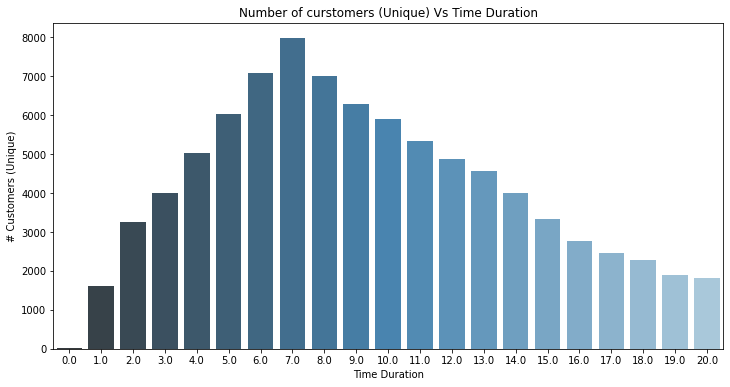

In [13]:
df_subset= df_orders[df_orders.time_duration <= 20]
df_by_duration = df_subset.groupby(['time_duration'])['customer_unique_id'].count().reset_index(drop = False)

#Modificación de Emmanuel G para embellecer
#Inicio(3) 
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.barplot(ax=ax
                , x="time_duration"
                , y="customer_unique_id"
                , data=df_by_duration
                , palette="Blues_d"                
               )
g.set(xlabel = 'Time Duration', ylabel = '# Customers (Unique)', title="Number of curstomers (Unique) Vs Time Duration")
#Fin(3)

Evidenciamos que la distribución al rededor de la grafica se concentra en los periodos comprendidos entre 0 y 7 dias de demora en entrega del producto, y continua decendiendo. ahora bien esto nos puede dar indicios queel promedio de demora no suele ser superior a los 7 dias para el promedio de datos de toda la base, pero es relevante compararlo con los scores en reviews para poder identificar algún patrón.

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:903: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, **kwargs)


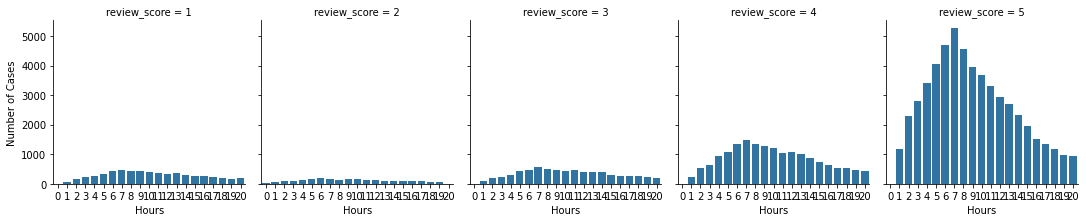

In [14]:
df_subset= df_orders[df_orders.time_duration <= 20]
df_subset.time_duration = df_subset.time_duration.astype(int)
df_by_duration = df_subset.groupby(['time_duration','review_score'])['customer_unique_id'].count().reset_index(drop = False)
g = sns.FacetGrid(df_by_duration, col = 'review_score')
g.set_xticklabels(fontsize=10)
g.map_dataframe(sns.barplot, x= 'time_duration', y = 'customer_unique_id')
g.set_axis_labels("Hours", "Number of Cases")

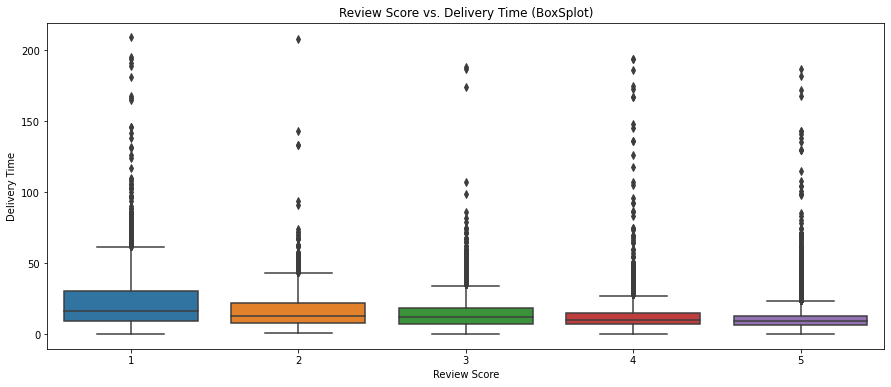

In [15]:
plt.figure(figsize=(15,6))
sns.boxplot(y = 'time_duration', x='review_score', data = df_orders)
#Modificación de Emmanuel para embellecer
#Inicio(4)
title_string = "Review Score vs. Delivery Time (BoxSplot)" 
plt.ylabel("Delivery Time")
plt.xlabel("Review Score")
#Fin(4)
_=plt.title(title_string)

Evidenciamos que a pesar que el score 5 en los reviews presenta más registros que los otros valores, en promedio el maximo tiempo de duración para las cinco calificaciones es 7 días. Otro dato relevante es que para el caso de un score de 1 y 2, parece que la distribución a lo largo de la duración de entrega es constante, pareciendo que pueden haber otras razones aparte de la duración de entrga que influya en la calificación.


Por lo anterior, podría ser interesante preguntarnos el coeficiente de correlación entre el socre de review y el numero de dias de entrega del producto, lo cual calculamos acontinuación:
    

In [16]:
#productos MAS vendidos:
df_products = df_items.groupby('product_category_name_english')['order_id'].count().reset_index(drop = False)
df_products = df_products.sort_values(by = 'order_id', ascending = False).reset_index(drop = True)
top_products = df_products.head(10)
top_products

,product_category_name_english,order_id
0,bed_bath_table,11746
1,health_beauty,10612
2,sports_leisure,9647
3,furniture_decor,8965
4,computers_accessories,8283
5,housewares,7295
6,watches_gifts,6358
7,telephony,4874
8,auto,4656
9,garden_tools,4575


In [17]:
#productos menos vendidos:
df_products = df_items.groupby('product_category_name_english')['order_id'].count().reset_index(drop = False)
df_products = df_products.sort_values(by = 'order_id', ascending = True).reset_index(drop = True)
deep_10_products = df_products.head(10)
deep_10_products

,product_category_name_english,order_id
0,security_and_services,2
1,fashion_childrens_clothes,8
2,la_cuisine,14
3,cds_dvds_musicals,14
4,arts_and_craftmanship,25
5,home_comfort_2,30
6,flowers,33
7,fashion_sport,35
8,music,39
9,furniture_mattress_and_upholstery,41


In [18]:
states = {
    'AC':' Acre',
'AL':' Alagoas',
'AP':' Amapá',
'AM':' Amazonas',
'BA':' Bahia',
'CE':' Ceará',
'DF':' Distrito Federal',
'ES':' Espírito Santo',
'GO':' Goiás',
'MA':' Maranhão',
'MT':' Mato Grosso',
'MS':' Mato Grosso do Sul',
'MG':' Minas Gerais',
'PA':' Pará',
'PB':' Paraíba',
'PR':' Paraná',
'PE':' Pernambuco',
'PI':' Piauí',
'RJ':' Rio de Janeiro',
'RN':' Rio Grande do Norte',
'RS':' Rio Grande do Sul',
'RO':' Rondônia',
'RR':' Roraima',
'SC':' Santa Catarina',
'SP':' São Paulo',
'SE':' Sergipe',
'TO':' Tocantins',
}

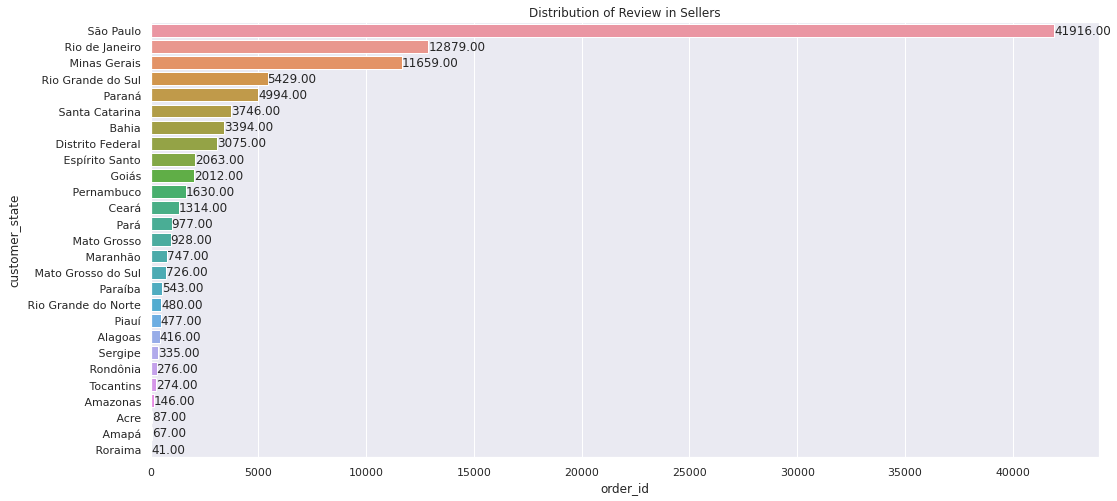

In [19]:
# plt.figure(figsize=(17,8))
# temp=df_orders.groupby('customer_state')['order_id'].count().sort_values(ascending=False).head(10).plot.bar()

plt.figure(figsize=(17,8))
a = df_orders.groupby('customer_state')['order_id'].count().sort_values(ascending=False).to_frame().reset_index()
a['customer_state'] = a['customer_state'].map(states)
a.head()

sns.set_color_codes("pastel")

sns.set(rc={'figure.figsize':(15,7)})
ax = sns.barplot(x="order_id", y="customer_state", data=a,label="Total")
ax.set(title='Distribution of Review in Sellers')

for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

Distribucion Reviews

<AxesSubplot:xlabel='review_score'>

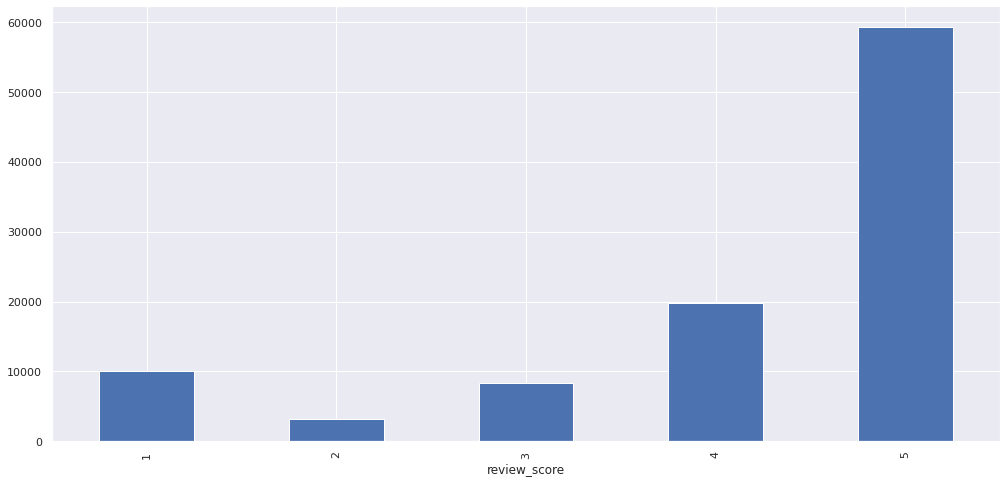

In [20]:
plt.figure(figsize=(17,8))
df_orders.groupby('review_score')['order_id'].count().plot.bar()

Cantidad de Clientes por cantidad de ordenes de cada cliente

(array([8.7412e+04, 5.0310e+03, 6.4100e+02, 2.0200e+02, 2.3000e+01,
        0.0000e+00, 3.5000e+01, 5.0000e+00, 4.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00]),
 array([ 1.        ,  1.82352941,  2.64705882,  3.47058824,  4.29411765,
         5.11764706,  5.94117647,  6.76470588,  7.58823529,  8.41176471,
         9.23529412, 10.05882353, 10.88235294, 11.70588235, 12.52941176,
        13.35294118, 14.17647059, 15.        ]),
 <BarContainer object of 17 artists>)

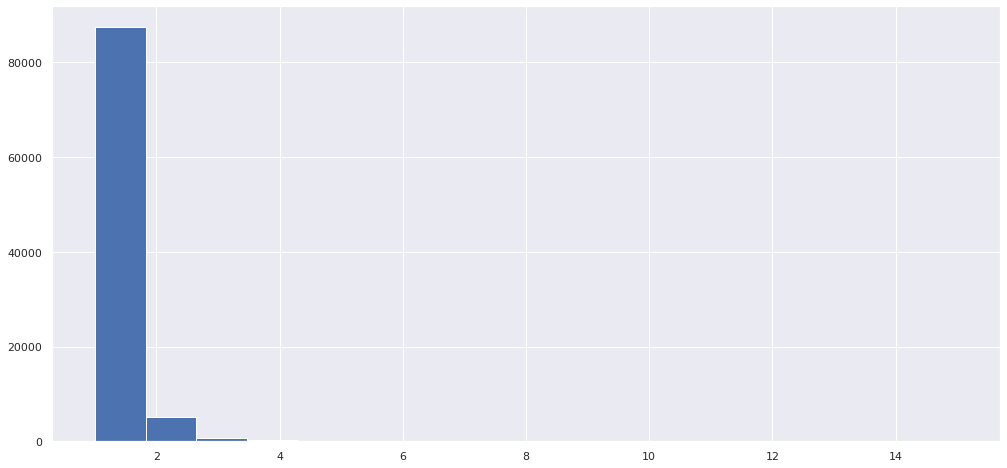

In [21]:
plt.figure(figsize=(17,8))
orders_client=df_orders.groupby('customer_unique_id')['order_id'].count().sort_values(ascending=False)
plt.hist(orders_client,17)

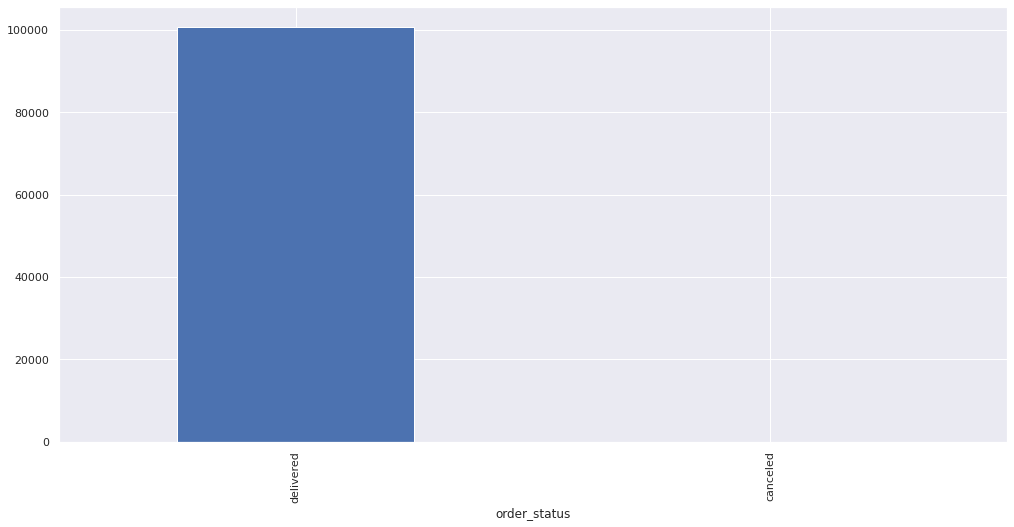

In [22]:
plt.figure(figsize=(17,8))
_=df_orders.groupby('order_status')['order_id'].count().sort_values(ascending=False).plot.bar()

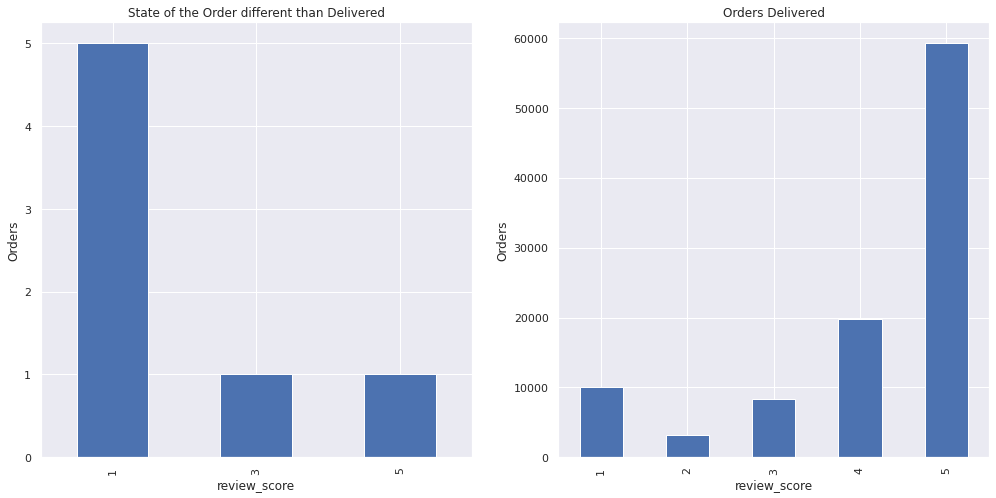

In [23]:
plt.figure(figsize=(17,8))
plt.subplot(121)
_=df_orders[df_orders.order_status!='delivered'].groupby('review_score')['order_id'].count().plot.bar()
plt.ylabel("Orders")
plt.xlabel="Review Score"
plt.title("State of the Order different than Delivered")
plt.subplot(122)
plt.ylabel("Orders")
plt.xlabel="Review Score"
plt.title("Orders Delivered")
_=df_orders[df_orders.order_status=='delivered'].groupby('review_score')['order_id'].count().plot.bar()

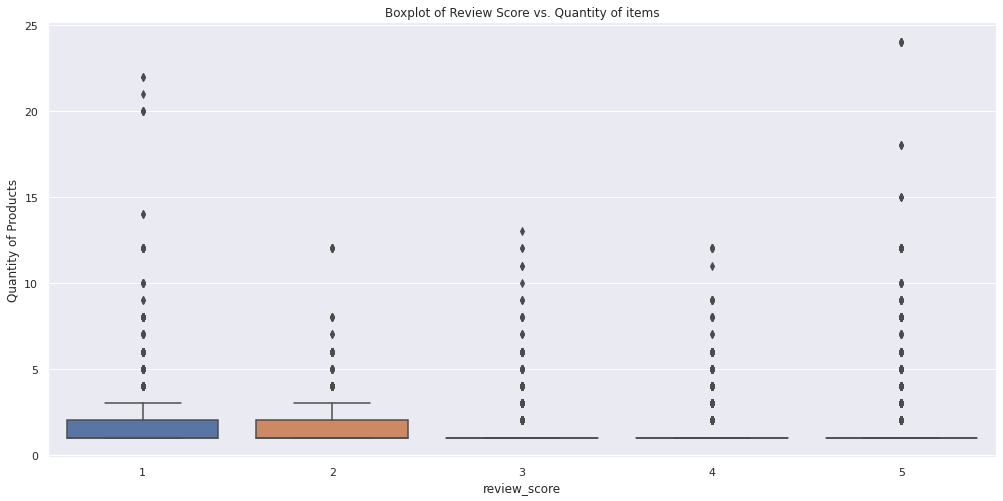

In [24]:
plt.figure(figsize=(17,8))
sns.boxplot(y = 'Q_products', x='review_score', data = df_orders)
title_string = "Boxplot of Review Score vs. Quantity of items" 
plt.ylabel("Quantity of Products")
_=plt.title(title_string)

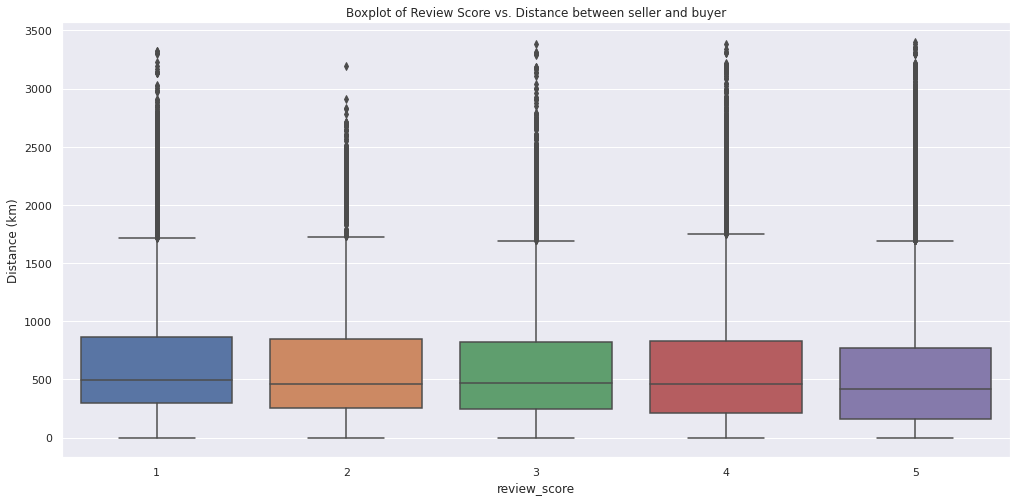

In [25]:
plt.figure(figsize=(17,8))
sns.boxplot(y = 'Distance', x='review_score', data = df_orders)
title_string = "Boxplot of Review Score vs. Distance between seller and buyer" 
plt.ylabel("Distance (km)")
plt.xlabel="Review Score"
_=plt.title(title_string)

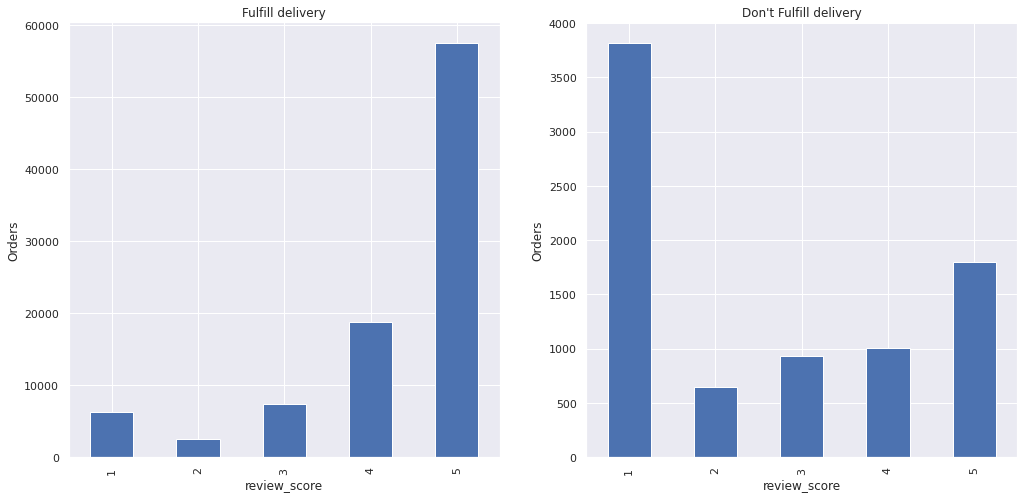

In [26]:
plt.figure(figsize=(17,8))
plt.subplot(121)
plt.title('Fulfill delivery')
plt.ylabel("Orders")
plt.xlabel="Review Score"
_=df_orders[df_orders.Fulfill_date==True].groupby('review_score')['order_id'].count().plot.bar()

plt.subplot(122)
plt.title("Don't Fulfill delivery")
plt.ylabel("Orders")
plt.xlabel="Review Score"
_=df_orders[df_orders.Fulfill_date==False].groupby('review_score')['order_id'].count().plot.bar()

# Pruebas de Hipotesis:


1. B0= El status del del producto no afecta la calificación del cliente:


In [27]:
statistic, pvalue = stats.ttest_ind(df_orders[df_orders.Fulfill_date==False].review_score,df_orders[df_orders.Fulfill_date==True].review_score, equal_var=False)
statistic, pvalue

(-92.6468127770201, 0.0)

In [28]:
mod = ols('review_score ~ order_status', data=df_orders).fit()  
aov_table = sm.stats.anova_lm(mod, typ=2)
aov_table

AttributeError: module 'statsmodels.formula.api' has no attribute 'stats'

2. b0 = El tiempo de duración del producto no afecta la calificación de los clientes. 

In [29]:
corr = df_orders.time_duration.corr(df_orders.review_score)
corr

-0.33424282545468154

In [30]:

statistic, pvalue = stats.ttest_ind(df_orders.time_duration,df_orders.review_score, equal_var=False)
statistic, pvalue


(262.07271143242383, 0.0)

3.B0 = comprarle a un seller con reviews altos no determina que la calificación del costumer sea acorde.

In [ ]:
df_orders

In [31]:

statistic, pvalue = stats.ttest_ind(df_orders.time_duration,df_orders.review_score, equal_var=False)
statistic, pvalue


(262.07271143242383, 0.0)

In [32]:
gb = df_orders.groupby(['order_status'])
group_names = df_orders["order_status"].unique()
print("\t\t\tstatistic\t\tpvalue")
len(group_names)
for i in range(len(group_names)):
    for j in range(i+1, len(group_names)):
        group1 = gb[["review_score"]].get_group(group_names[i])
        group2 = gb[["review_score"]].get_group(group_names[j])
        stat, pvalue = stats.ttest_ind(group1, group2, equal_var = False)
        print(group_names[i] + " vs. " + group_names[j] + "\t" + str(stat[0]) + "\t" + str(pvalue[0]))

			statistic		pvalue
delivered vs. canceled	3.841015650184008	0.008547267402334864


In [33]:
pairwise_results = pairwise_ttests(dv='review_score', between = ['order_status'], padjust='bonf', data=df_orders)
pairwise_results

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,order_status,delivered,canceled,False,True,3.841016,6.000567,two-sided,0.008547,148.326,1.761544


In [34]:
## DB Conection

con = snowflake.connector.connect(
          user='CAMILOCBARRERA',
         password='Datos112020',
          account='ioa22652.us-east-1',
          warehouse='DS4A_WH',
          database='BRAZILIAN_ECOMMERCE_DB',
          )
def runQueryDF(sql):
    cursor=con.cursor()
    cursor.execute(sql)
    result=cursor.fetchall()
    df=pd.DataFrame(result)
    df.columns = [x.lower() for x in list(map(lambda t: t[0], cursor.description))]
    return df

In [35]:
sql = """

WITH max_dates AS
(
select 
order_id, 
max(REVIEW_ANSWER_TIMESTAMP) REVIEW_ANSWER_TIMESTAMP
from order_reviews 
GROUP BY 1
)
,review AS
(
select 
rev.order_id,
rev.review_score
from order_reviews  rev
inner join max_dates  dat on rev.REVIEW_ANSWER_TIMESTAMP = dat.REVIEW_ANSWER_TIMESTAMP  AND rev.order_id = dat.order_id 
)
,o_sellers AS
(
select distinct
order_id,
seller_id
from order_items
group by 1,2
)

SELECT
seller_id,
avg(re.review_score) review_score,
count(distinct oi.order_id) as total_orders
FROM review re
inner join order_items oi on re.order_id = oi.order_id
group by 1 order by 2

"""

In [36]:
seller_review = runQueryDF(sql)

In [37]:
seller_review.head()

,seller_id,review_score,total_orders
0,6e85dc5ecd97a61094b89b046a509d8e,1.000000,1
1,7a073a40a9d3f1fee8bc45670ea1e909,1.000000,1
2,3a79f35a2344ede41af21267f61d5ec6,1.000000,1
3,913fd0ebba70bb919f7254a02239173c,1.000000,1
4,1967a9e2ad6f51802b093147d861df58,1.000000,2


ValueError: max() arg is an empty sequence

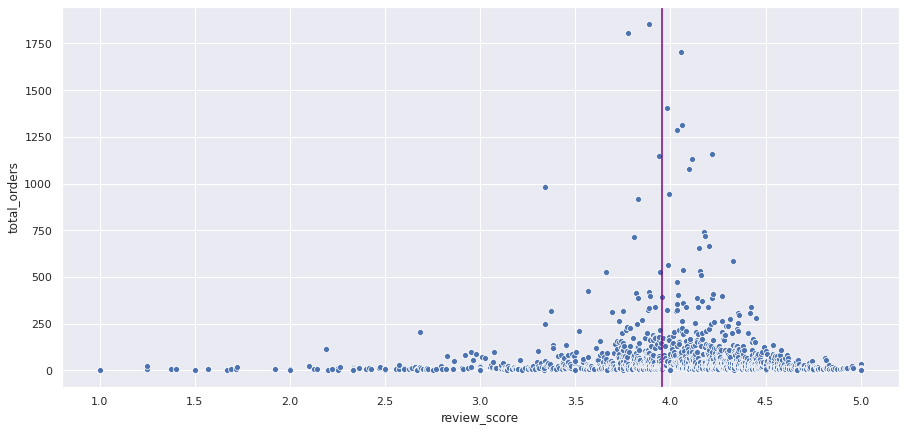

In [40]:
## Seller rating and orders 

sns.set(rc={'figure.figsize':(15,7)})




ax=sns.scatterplot(data=seller_review, x="review_score", y="total_orders")
plt.axvline(seller_review['review_score'].mean(), color='purple', label='Mean') ##Add Mean of review sellers
# plt.axvline(seller_review['review_score'].median(), color='blue', label='Mean') ##Add Median of review sellers


plt.text(x = seller_review['review_score'].mean(), # x-coordinate position of data label, adjusted to be 3 right of the data point
 y = max([h.get_height() for h in ax.patches]), # y-coordinate position of data label, to take max height 
 s = 'mean: {:.0f}'.format(seller_review['review_score'].mean()), # data label
 color = 'purple') # colour of the vertical mean line

# plt.savefig("selerres_review_scatter.png")

In [41]:
corr = df_orders.time_duration.corr(df_orders.review_score)
corr

-0.33424282545468154

Text(0, 0.5, 'percentage of reviews')

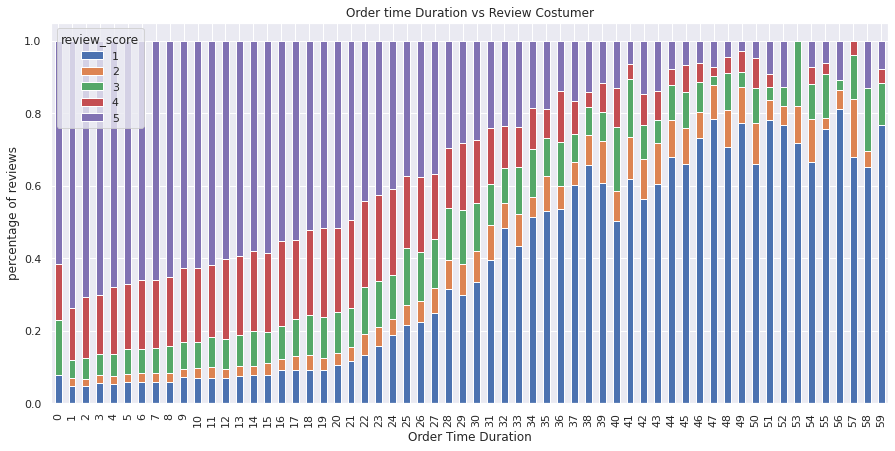

In [45]:
temp=df_orders.groupby(['time_duration','review_score'])['order_id'].count().reset_index()
temp2=temp.pivot_table(index=('time_duration'),columns=('review_score'),values='order_id').reset_index()
temp2=temp2.fillna(0)
temp2=temp2[(temp2.time_duration<60)]
temp2['Suma']=temp2[1]+temp2[2]+temp2[3]+temp2[4]+temp2[5]
x= temp2[[1,2,3,4,5]].div(temp2.Suma, axis=0)
x.plot(kind='bar',stacked=True, xlabel = 'Order Time Duration')
plt.title('Order time Duration vs Review Costumer')
plt.ylabel('percentage of reviews')

In [43]:
corr_mat  = df_orders.corr()
corr_mat

,customer_zip_code_prefix,review_score,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,Q_products,Distance,Fulfill_date,time_duration
customer_zip_code_prefix,1.000000,-0.021832,1.000000,0.133683,-0.309541,0.022002,0.487431,-0.025714,0.269650
review_score,-0.021832,1.000000,-0.021997,-0.042555,-0.051207,-0.092941,-0.061631,0.364878,-0.334243
geolocation_zip_code_prefix,1.000000,-0.021997,1.000000,0.133683,-0.309541,0.022430,0.487431,-0.025647,0.269903
geolocation_lat,0.133683,-0.042555,0.133683,1.000000,0.437228,0.011182,0.707289,-0.054904,0.255281
geolocation_lng,-0.309541,-0.051207,-0.309541,0.437228,1.000000,-0.021773,0.218023,-0.074729,0.110979
Q_products,0.022002,-0.092941,0.022430,0.011182,-0.021773,1.000000,-0.008704,0.010403,-0.012404
Distance,0.487431,-0.061631,0.487431,0.707289,0.218023,-0.008704,1.000000,-0.067575,0.389296
Fulfill_date,-0.025714,0.364878,-0.025647,-0.054904,-0.074729,0.010403,-0.067575,1.000000,-0.591866
time_duration,0.269650,-0.334243,0.269903,0.255281,0.110979,-0.012404,0.389296,-0.591866,1.000000


In [46]:
sql = """
select * from data_orders
"""
data_orders = runQueryDF(sql)


In [47]:
df_orders=df_orders.merge(data_orders[['order_id','seller_rating','seller_total_orders']],how='left',on='order_id')
df_orders.seller_rating=df_orders.seller_rating.apply(float)

3.B0 = comprarle a un seller con reviews altos no determina que la calificación del costumer sea acorde.

In [48]:
chi_time_duration=pd.crosstab(df_orders['time_duration'],df_orders['review_score'])
g, p, dof, expctd = chi2_contingency(chi_time_duration)
print("p-value of Chi-square test for Time between Purchase and Delivery vs. Single Order Review Score =", p)
chi_time_duration

p-value of Chi-square test for Time between Purchase and Delivery vs. Single Order Review Score = 0.0


review_score,1,2,3,4,5
time_duration,,,,,
0.0,1,0,2,2,8
1.0,86,44,83,236,1200
2.0,177,73,195,554,2323
3.0,263,99,244,655,2829
4.0,301,120,325,954,3431
...,...,...,...,...,...
191.0,1,0,0,0,0
194.0,1,0,0,2,0
195.0,1,0,0,0,0


In [49]:
chi_seller_rating=pd.crosstab(df_orders['seller_rating'],df_orders['review_score'])
g, p, dof, expctd = chi2_contingency(chi_seller_rating)
print("p-value of Chi-square test for Seller Average Rating vs. Single Order Review Score =", p)
chi_seller_rating

p-value of Chi-square test for Seller Average Rating vs. Single Order Review Score = 0.0


review_score,1,2,3,4,5
seller_rating,,,,,
1.000000,70,0,0,0,0
1.250000,3,1,0,0,0
1.400000,2,0,1,0,0
1.500000,5,3,1,0,0
1.571429,5,0,1,0,0
...,...,...,...,...,...
4.909091,0,0,0,3,31
4.923077,0,0,0,2,25
4.947368,0,0,0,1,20


In [50]:
chi_seller_size=pd.crosstab(df_orders['seller_total_orders'],df_orders['review_score'])
g, p, dof, expctd = chi2_contingency(chi_seller_size)
print("p-value of Chi-square test for Order Status vs. Single Order Review Score =", p)
chi_seller_size

p-value of Chi-square test for Order Status vs. Single Order Review Score = 2.5372340655561122e-232


review_score,1,2,3,4,5
seller_total_orders,,,,,
1,54,12,34,75,313
2,70,11,56,132,366
3,78,19,44,114,376
4,53,13,48,124,384
5,57,19,45,128,464
...,...,...,...,...,...
1314,122,47,123,278,807
1404,161,45,105,266,872
1706,172,57,173,309,1066


In [51]:
chi_order_status=pd.crosstab(df_orders['order_status'],df_orders['review_score'])
g, p, dof, expctd = chi2_contingency(chi_order_status)
print("p-value of Chi-square test for Order Status vs. Single Order Review Score =", p)
chi_order_status

p-value of Chi-square test for Order Status vs. Single Order Review Score = 7.216443876631474e-06


review_score,1,2,3,4,5
order_status,,,,,
canceled,5,0,1,0,1
delivered,10643,3292,8546,19892,59643


In [53]:
model1 = 'review_score~time_duration + Fulfill_date + seller_rating'
lm1   = sm.ols(formula = model1, data = df_orders).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     7605.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:59:40   Log-Likelihood:            -1.6218e+05
No. Observations:              102023   AIC:                         3.244e+05
Df Residuals:                  102019   BIC:                         3.244e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1923 